# Linear Regression

Try to apply a linear regression model to the merged otu table

In [1]:
import csv
import logging

import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from src import project_directory
from src.database import get_session, Sample

In [2]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)

Ok simply load otu table and then add tissue as metadata:

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [4]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['H_10_S10_L001' 'H_11_S11_L001' 'H_12_S12_L001' 'H_13_S13_L001'
 'H_14_S14_L001' 'H_15_S15_L001' 'H_16_S16_L001' 'H_17_S17_L001'
 'H_18_S18_L001' 'H_19_S19_L001']


In [5]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}

In [ ]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[:3])

(defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fca4bce3e50>, {'tissue': 'hindgut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fca4e08c940>, {'tissue': 'hindgut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fca4bc8bdc0>, {'tissue': 'hindgut'}))


Transform the otu table to a pandas dataframe and then add the tissue as metadata.
Table should be transposed to have samples as rows and otus as columns.

In [7]:
# Convert the OTU table to a dataframe
otu_df = pd.DataFrame(table.matrix_data.toarray(), index=table.ids(axis='observation'), columns=table.ids(axis='sample'))

# Add the tissue metadata as a new column
otu_df = otu_df.transpose()
otu_df['tissue'] = otu_df.index.map(sample2tissue)

In [8]:
otu_df["tissue"].value_counts()

tissue
milk       379
gut        296
rumen      168
hindgut    141
Name: count, dtype: int64

Transform tables:

In [9]:
X = otu_df.drop(columns=["tissue"])
y = otu_df["tissue"]

In [10]:
# random_state:
# https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Creating a model

In [11]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [12]:
model = LogisticRegression(solver="liblinear", max_iter=1000)
ovr_classifier = OneVsRestClassifier(model)

In [13]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [14]:
grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, verbose=1, cv=5)

In [15]:
grid_search.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [16]:
grid_search.best_params_

{'C': 1, 'penalty': 'l1'}

In [17]:
y_pred = grid_search.predict(scaled_X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9966216216216216
Classification Report:
              precision    recall  f1-score   support

         gut       0.99      1.00      1.00       100
     hindgut       1.00      0.98      0.99        42
        milk       1.00      1.00      1.00       114
       rumen       1.00      1.00      1.00        40

    accuracy                           1.00       296
   macro avg       1.00      0.99      1.00       296
weighted avg       1.00      1.00      1.00       296



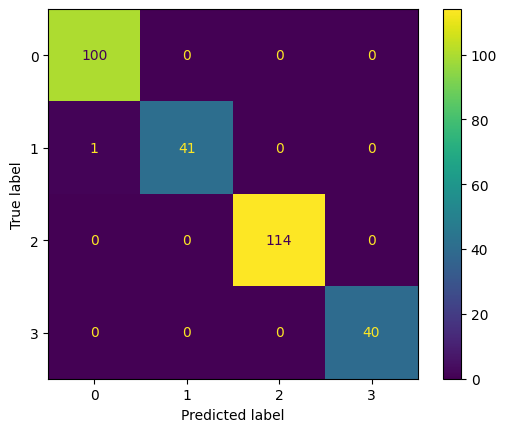

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The same confusion matrix as before but with class labels:

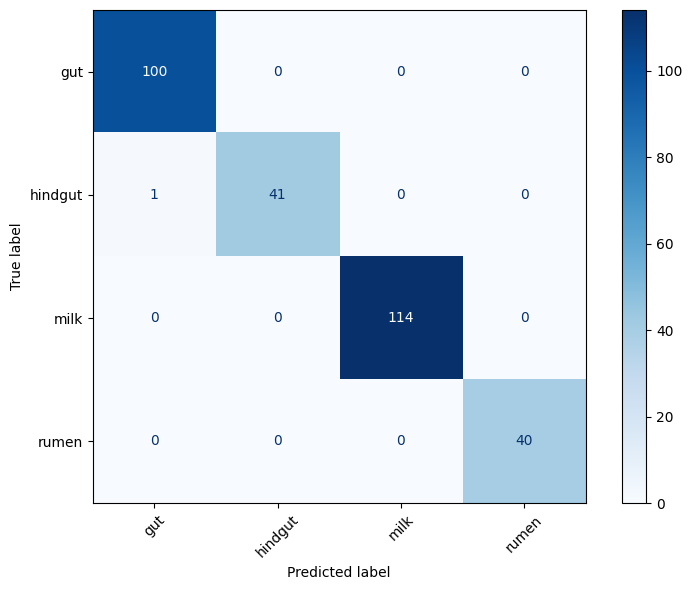

In [20]:
# fallback: unione ordinata di y_true e y_pred per garantire tutte le etichette
class_names = np.unique(np.concatenate([y_test.astype(str), y_pred.astype(str)]))

# Ricomponi la confusion matrix usando le etichette testuali e visualizza
cm = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", values_format='d')
plt.tight_layout()
plt.show()

Get the best model and save it to a file:

In [21]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, project_directory / "notebooks/logistic_regression_model.pkl")

['/home/cozzip/deep_micro_core/notebooks/logistic_regression_model.pkl']

Now try to collect the coefficients to identify the features that are more important for the model.

In [22]:
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({'Feature ID': X.columns, 'Coefficient': coefficients})
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance.set_index('Feature ID', inplace=True)
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

,Coefficient,Importance
Feature ID,,
e35717a58b264c434096a2170f57d323,0.418421,0.418421
b02a8d33d018119dedb2db15db887bfd,-0.365034,0.365034
47077b5b0b09ae34e3eee37f67a76d98,0.353652,0.353652
d61565ed1ee64af0851b0d18938ad391,0.312032,0.312032
1fd5352a0ffcd14117a9cbd98ef318b0,0.288777,0.288777
cf90d1ad0f88ebd7ccf72578fd1699b0,0.280953,0.280953
043487000d365044e5057604f79611ca,0.279555,0.279555
f666eee1317a044372234466fa37393f,0.278170,0.278170
ee6c2b8ed5439b2676609eaa783c520a,0.276055,0.276055


try to load the taxononies from file

In [23]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}
taxonomies = {key: value.split(";")[:-1] for key, value in taxonomies.items()}
taxonomies = pd.DataFrame.from_dict(taxonomies, orient='index', columns=[f"Level_{i}" for i in range(1, 9)])
taxonomies.index.name = "Feature ID"
taxonomies.head()

,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,
00005da053b2c7b99c1f46889cbd7d33,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,,,,
000064ab480f315e268221d5ee0f9297,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Anaerovibrio,,
0000b0dfd1e9fb1b144a521a5d59c29c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,,,
0000e116cc2f5406e876821a7c052ded,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Roseiflexaceae,,,
0001caade39e8c23666cfaefa5b5543c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,,


In [24]:
merged_df = feature_importance.merge(taxonomies, left_index=True, right_index=True, how="inner")
merged_df.to_csv(project_directory / "notebooks/feature_importance.csv", index=False)
merged_df.head()

,Coefficient,Importance,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,,,
e35717a58b264c434096a2170f57d323,0.418421,0.418421,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Ligilactobacillus,,
b02a8d33d018119dedb2db15db887bfd,-0.365034,0.365034,Bacteria,Actinobacteriota,Actinobacteria,Propionibacteriales,Propionibacteriaceae,Cutibacterium,acnes,
47077b5b0b09ae34e3eee37f67a76d98,0.353652,0.353652,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,,
d61565ed1ee64af0851b0d18938ad391,0.312032,0.312032,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Ligilactobacillus,,
1fd5352a0ffcd14117a9cbd98ef318b0,0.288777,0.288777,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Ligilactobacillus,,
